# Load libraries and set the coordinate system

In [1]:
%pylab inline

import numpy as np
import cvxpy
from cvxpy import Variable, Minimize, sum_squares, norm, Problem, Parameter, mul_elemwise, sum_entries, Constant
from scipy import sparse
import sys, argparse
from scipy import ndimage
import matplotlib
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
import matplotlib.gridspec as gridspec

from PIL import Image

sys.path.append('../../')
from tractionforce.elasticity import *
import gc
from tractionforce.norms import *
from tractionforce.problem import *

from joblib import Parallel, delayed
import multiprocessing

"""
Set up the domain and the grid
"""

im = Image.open('padmask.tif')
imarray = np.flip(np.array(im),0)

N = 160
M = 120

#N = 640
#M = 480

x_forward_positions = np.arange(N)
y_forward_positions = np.arange(M)

dx = abs(x_forward_positions[1]-x_forward_positions[0])
dy = abs(y_forward_positions[1]-y_forward_positions[0])

forward_coords = [[ [x,y] for x in x_forward_positions] for y in y_forward_positions] 
forward_coords = np.array([item for sublist in forward_coords for item in sublist])

scaling = 25


r1 = 1.0/5*scaling
r2 = 1.0/6*scaling
r3 = 1.0/8*scaling
r4 = 1.0/4*scaling

c1 = np.array((-1,-1/2.))
c2 = np.array((0,-1))
c3 = np.array((2,1))
c4 = np.array((0,1))



d1 = ((forward_coords[:,0]-N/2.-c1[0]*scaling)**2 + (forward_coords[:,1]-M/2-c1[1]*scaling)**2)**0.5 # already up-scaled
d2 = ((forward_coords[:,0]-N/2.-c2[0]*scaling)**2 + (forward_coords[:,1]-M/2-c2[1]*scaling)**2)**0.5
d3 = ((forward_coords[:,0]-N/2.-c3[0]*scaling)**2 + (forward_coords[:,1]-M/2-c3[1]*scaling)**2)**0.5
d4 = ((forward_coords[:,0]-N/2.-c4[0]*scaling)**2 + (forward_coords[:,1]-M/2-c4[1]*scaling)**2)**0.5

A1 = np.pi * r1**2
A2 = np.pi * r2**2
A3 = np.pi * r3**2
A4 = np.pi * r4**2



def latex_float(f):
    float_str = "{0:.2g}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"{0} \times 10^{{{1}}}".format(base, int(exponent))
    else:
        return float_str

Populating the interactive namespace from numpy and matplotlib


# Generate the stress field

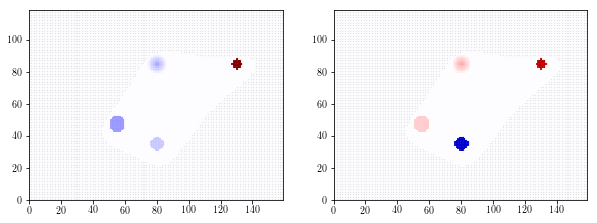

In [2]:
_FORWARD_CUT_OFF = 50
_CUTOFF  = 16


a12 = 1e-4
a23 = 2e-4
g4 = 9e-5

G4 = g4*pi*(r4)**2/3.

s1_x = a12
s1_y = -a12/2.

s2_x = -a12*A1/A2 + a23
s2_y = G4/A2+a12*A1/A2/2. + a23

s3_x = -G4/A3 - a23*A2/A3
s3_y = -a23*A2/A3


in_1 = d1<=r1 
in_2 = d2<=r2 
in_3 = d3<=r3 
in_4 = d4<=r4 

stress_x = np.zeros(forward_coords.shape[0])
stress_y = np.zeros(forward_coords.shape[0])

stress_x[in_1] = s1_x * A1/sum(in_1)
stress_y[in_1] = s1_y * A1/sum(in_1)


stress_x[in_2] = s2_x * A2/sum(in_2)
stress_y[in_2] = s2_y * A2/sum(in_2)

stress_x[in_3] = s3_x * A3/sum(in_3)
stress_y[in_3] = s3_y * A3/sum(in_3)

stress_x[in_4] = g4*(1-d4[in_4]/r4)
stress_y[in_4] = -g4*(1-d4[in_4]/r4)

stress_x[in_4] *= G4/sum(stress_x[in_4])
stress_y[in_4] *= -G4/sum(stress_y[in_4])

# add the cone for region 4

max_s = np.max(np.abs(stress_x))

fig = plt.figure(figsize=(10,6))
plt.subplot(121)
plt.pcolormesh(x_forward_positions,y_forward_positions,imarray==0,
                           cmap='gray').axes.set_aspect('equal')
plt.pcolormesh(x_forward_positions,y_forward_positions,stress_x.reshape((M,N)),
                           cmap='seismic_r',vmin=-max_s,vmax=max_s,alpha=0.9).axes.set_aspect('equal')
plt.subplot(122)
plt.pcolormesh(x_forward_positions,y_forward_positions,imarray==0,
                           cmap='gray').axes.set_aspect('equal')
plt.pcolormesh(x_forward_positions,y_forward_positions,stress_y.reshape((M,N)),
                           cmap='seismic_r',vmin=-max_s,vmax=max_s,alpha=0.9).axes.set_aspect('equal')



In [3]:
print("Total torque: " + str(sum((forward_coords[:,0]-N/2)*stress_y - (forward_coords[:,1]-M/2)*stress_x)))
print("Total force-x: " + str(sum(stress_x)))
print("Total force-y: " + str(sum(stress_y)))

Total torque: -5.55111512313e-17
Total force-x: 1.73472347598e-18
Total force-y: 1.73472347598e-18


In [4]:

mask = imarray == 0

distances2d = -ndimage.distance_transform_edt(mask) + ndimage.distance_transform_edt(1 - mask)
distances2d = distances2d.flatten()



condition_inside = distances2d<=0
condition_outside = (distances2d>0) * (distances2d<=_FORWARD_CUT_OFF)




# Solve the forward problem over the specified subdomain

In [5]:
x_out = np.array(forward_coords[condition_outside,0],dtype=int)
y_out = np.array(forward_coords[condition_outside,1],dtype=int)

x_in = np.array(forward_coords[condition_inside,0],dtype=int)
y_in = np.array(forward_coords[condition_inside,1],dtype=int)

x_center = np.mean(x_in)
y_center = np.mean(y_in)

G_in_in_xx, G_in_in_xy, G_out_in_xx, G_out_in_xy, G_in_in_yy, G_in_in_yx, G_out_in_yy, G_out_in_yx, Dx, Dy = gen_matrices(x_in,y_in,x_out,y_out,dx,dy,loworder = True)

Size of the problem is 17696


/usr/local/lib/python3.6/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [6]:
# Generate the measured dispalcements
s_x = stress_x[condition_inside]
s_y = stress_y[condition_inside]

u_in_x = G_in_in_xx.dot(s_x) + G_in_in_xy.dot(s_y)
u_out_x = G_out_in_xx.dot(s_x) + G_out_in_xy.dot(s_y)

u_in_y = G_in_in_yx.dot(s_x) + G_in_in_yy.dot(s_y)
u_out_y = G_out_in_yx.dot(s_x)  + G_out_in_yy.dot(s_y)

u_x = np.zeros(forward_coords.shape[0])
u_x[condition_inside] = u_in_x
u_x[condition_outside] = u_out_x

u_y = np.zeros(forward_coords.shape[0])
u_y[condition_inside] = u_in_y
u_y[condition_outside] = u_out_y


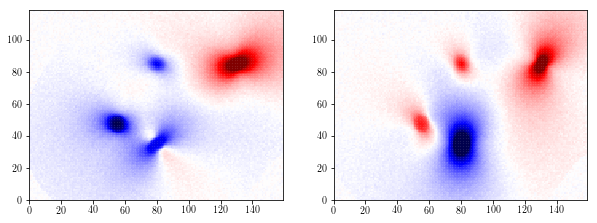

In [7]:
max_s = np.max(u_x)

fig = plt.figure(figsize=(10,12))
plt.subplot(121)
plt.pcolormesh(x_forward_positions,y_forward_positions,imarray==0,
                           cmap='Greens').axes.set_aspect('equal')
plt.pcolormesh(x_forward_positions,y_forward_positions,u_x.reshape((M,N)),
                           cmap='seismic_r',vmin=-max_s,vmax=max_s,alpha=0.9).axes.set_aspect('equal')
plt.subplot(122)
plt.pcolormesh(x_forward_positions,y_forward_positions,imarray==0,
                           cmap='Greens').axes.set_aspect('equal')
plt.pcolormesh(x_forward_positions,y_forward_positions,u_y.reshape((M,N)),
                           cmap='seismic_r',vmin=-max_s,vmax=max_s,alpha=0.9).axes.set_aspect('equal')


noise = 1e-5

obs_x = u_x.reshape((M,N)) + np.random.normal(0,noise,size=(M,N))
obs_y = u_y.reshape((M,N)) + np.random.normal(0,noise,size=(M,N))

plt.subplot(221)

plt.pcolormesh(x_forward_positions,y_forward_positions,obs_x,
                           cmap='seismic_r',vmin=-max_s,vmax=max_s,alpha=0.9).axes.set_aspect('equal')
#plt.pcolormesh(x_forward_positions,y_forward_positions,imarray==0,
#                           cmap='Greens',alpha=0.04).axes.set_aspect('equal')

plt.subplot(222)
#plt.pcolormesh(x_forward_positions,y_forward_positions,imarray==0,
#                           cmap='gray').axes.set_aspect('equal')
plt.pcolormesh(x_forward_positions,y_forward_positions,obs_y,
                           cmap='seismic_r',vmin=-max_s,vmax=max_s,alpha=0.9).axes.set_aspect('equal')


# Coarsen

In [8]:
spacing = 2

x_obs_positions = np.arange(0,N,spacing)
y_obs_positions = np.arange(0,M,spacing)

dx = abs(x_obs_positions[1]-x_obs_positions[0])
dy = abs(y_obs_positions[1]-y_obs_positions[0])

coords = [[ [x,y] for x in x_obs_positions] for y in y_obs_positions] 
coords = np.array([item for sublist in coords for item in sublist])

# generate the conditions

distancefun = np.array([distances2d.reshape((M,N))[a[1],a[0]] for a in coords]) # stupid but works


condition_inside = distancefun<=0
condition_outside = (distancefun>0) * (distancefun<=_CUTOFF)

# obtain the observations

obs_x_in = np.array([obs_x[a[1],a[0]] for a,cond in zip(coords,condition_inside)if cond] )
obs_x_out = np.array([obs_x[a[1],a[0]] for a,cond in zip(coords,condition_outside)if cond] )

obs_y_in = np.array([obs_y[a[1],a[0]] for a,cond in zip(coords,condition_inside)if cond] )
obs_y_out = np.array([obs_y[a[1],a[0]] for a,cond in zip(coords,condition_outside)if cond] )

# Regenerate the matrices

In [9]:
x_out = np.array(coords[condition_outside,0]/dx,dtype=int)
y_out = np.array(coords[condition_outside,1]/dy,dtype=int)

x_in = np.array(coords[condition_inside,0]/dx,dtype=int)
y_in = np.array(coords[condition_inside,1]/dy,dtype=int)



G_in_in_xx, G_in_in_xy, G_out_in_xx, G_out_in_xy, G_in_in_yy, G_in_in_yx, G_out_in_yy, G_out_in_yx, Dx, Dy = gen_matrices(x_in,y_in,x_out,y_out,dx*spacing,dy*spacing,loworder = True)

Size of the problem is 2200


/usr/local/lib/python3.6/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [10]:
N_SOLUTIONS = 24
gamma_vals = np.logspace(-7, -3.5, N_SOLUTIONS)


# Coords are 1:100 in each direction
# annulus centered
# inner radius 20
# outer radius 30
# boundary radius 35

gamma = Parameter(sign="positive",value=1)

n_in = len(x_in)
x_center = np.mean(x_in)
y_center = np.mean(y_in)

sigma_xz = Variable(n_in)
sigma_yz = Variable(n_in)
predicted_in_x = G_in_in_xx * sigma_xz + G_in_in_xy * sigma_yz
predicted_out_x = G_out_in_xx * sigma_xz + G_out_in_xy * sigma_yz
predicted_in_y = G_in_in_yx * sigma_xz + G_in_in_yy * sigma_yz
predicted_out_y = G_out_in_yx * sigma_xz + G_out_in_yy * sigma_yz


error = sum_squares(obs_y_in - predicted_in_y) + sum_squares(obs_y_out - predicted_out_y) 

forceconstraints = [sum_entries(sigma_xz)==0, sum_entries(sigma_yz)==0] # add torque-free constraint here
net_torque = sum_entries(mul_elemwise(x_in-x_center,sigma_yz) - mul_elemwise(y_in-y_center,sigma_xz))

torqueconstraints = [net_torque == 0]

constraints = forceconstraints + torqueconstraints
#constraints = []

In [11]:
regularity_penalty = norm(sigma_xz+sigma_yz,p=1)
objective = Minimize(error + gamma*regularity_penalty)
prob = Problem(objective, constraints)

sq_penalty = []
l1_penalty = []
sigma_xz_values = []
sigma_yz_values = []

u_x_values = []
u_y_values = []

In [12]:
#num_cores = multiprocessing.cpu_count() - 4
num_cores = 2

def invert_one(val):
    gamma.value = val
    try:
        prob.solve(verbose= True, max_iters = 50,
                   warm_start=True, solver = cvxpy.CVXOPT,
                   feastol = 1e-7, reltol = 1e-6,
                   abstol = 1e-7)

    except cvxpy.SolverError:
        return None

    sq_penalty.append(error.value)
    l1_penalty.append(regularity_penalty.value)
    sigma_xz_values.append(sigma_xz.value)
    sigma_yz_values.append(sigma_yz.value)

    s_x = np.zeros(coords.shape[0])
    s_y = np.zeros(coords.shape[0])
    
    s_x[condition_inside].flat = sigma_xz.value.reshape((n_in,))
    s_y[condition_inside].flat = sigma_yz.value.reshape((n_in,))

    u_x = np.zeros(coords.shape[0])
    u_y = np.zeros(coords.shape[0])
    u_x[condition_inside].flat = predicted_in_x.value
    u_x[condition_outside].flat = predicted_out_x.value
    u_y[condition_inside].flat = predicted_in_y.value
    u_y[condition_outside].flat = predicted_out_y.value
    
    return np.array([sigma_xz.value, sigma_yz.value]).T, error.value, regularity_penalty.value, val

    return np.array([s_x, s_y]).T,  error.value, regularity_penalty.value, val


#results = Parallel(n_jobs=num_cores)(delayed(invert_one)(val) for val in gamma_vals)
results = [invert_one(val) for val in gamma_vals]

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.0000e+00  2e+03  2e+01  4e+01  1e+00
 1:  1.7734e-02 -1.3826e-02  7e+01  1e+00  2e+00  1e-01
 2:  2.5562e-04 -1.3558e-04  7e-01  1e-02  2e-02  1e-03
 3:  4.8540e-05 -1.1648e-06  3e-02  4e-04  9e-04  1e-05
 4:  3.9286e-06 -3.3630e-08  1e-04  3e-05  6e-05  1e-08
 5:  2.2830e-07 -2.5067e-08  6e-07  2e-06  4e-06  1e-08
 6:  1.3580e-07  1.1391e-07  3e-08  2e-07  3e-07  2e-10
 7:  1.2466e-07  1.1612e-07  1e-08  6e-08  1e-07  6e-11
 8:  1.2013e-07  1.1703e-07  4e-09  2e-08  5e-08  2e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.0000e+00  2e+03  2e+01  4e+01  1e+00
 1:  1.7751e-02 -1.3826e-02  7e+01  1e+00  2e+00  1e-01
 2:  2.7603e-04 -1.3554e-04  7e-01  1e-02  2e-02  1e-03
 3:  6.6374e-05 -1.1404e-06  3e-02  6e-04  1e-03  1e-05
 4:  1.6907e-06 -2.2484e-08  2e-05  1e-05  3e-05  4e-09
 5:  2.2945e-07 -4.3519e-08  5e-07  2e-06  4e-06  5e-09
 6:  1.3785e-07  1.0804e-07 

 9:  1.8245e-07  1.6255e-07  3e-08  2e-07  3e-07  7e-10
10:  1.7390e-07  1.6684e-07  1e-08  5e-08  1e-07  2e-10
11:  1.7049e-07  1.6797e-07  3e-09  2e-08  4e-08  5e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.0000e+00  2e+03  2e+01  4e+01  1e+00
 1:  2.1525e-02 -1.3779e-02  7e+01  1e+00  2e+00  1e-01
 2:  4.5347e-03 -1.2713e-04  2e+00  4e-02  9e-02  1e-03
 3:  4.1965e-04 -1.4609e-05  2e-02  3e-03  6e-03  1e-06
 4:  4.4690e-06 -1.2751e-05  3e-05  1e-04  3e-04  1e-06
 5:  1.0434e-06 -4.6202e-07  2e-06  1e-05  2e-05  6e-08
 6:  3.6938e-07  2.7876e-08  5e-07  3e-06  5e-06  1e-08
 7:  2.5228e-07  1.2712e-07  2e-07  1e-06  2e-06  4e-09
 8:  2.1403e-07  1.6402e-07  7e-08  4e-07  8e-07  2e-09
 9:  2.0324e-07  1.7678e-07  4e-08  2e-07  4e-07  6e-10
10:  1.9454e-07  1.8246e-07  2e-08  9e-08  2e-07  2e-10
11:  1.8825e-07  1.8544e-07  4e-09  2e-08  4e-08  4e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: 

 4:  2.1502e-05 -4.2319e-07  4e-05  2e-04  4e-04  7e-06
 5:  4.7467e-06  8.9537e-07  6e-06  4e-05  7e-05  1e-06
 6:  2.5690e-06  1.6443e-06  1e-06  9e-06  2e-05  2e-07
 7:  2.5138e-06  1.6762e-06  1e-06  8e-06  2e-05  2e-07
 8:  2.2804e-06  1.8515e-06  7e-07  4e-06  7e-06  7e-08
 9:  2.1144e-06  1.8770e-06  4e-07  2e-06  4e-06  3e-08
10:  1.9699e-06  1.9104e-06  9e-08  5e-07  1e-06  5e-09
11:  1.9307e-06  1.9133e-06  3e-08  1e-07  3e-07  9e-10
12:  1.9193e-06  1.9150e-06  6e-09  3e-08  7e-08  2e-10
Optimal solution found.


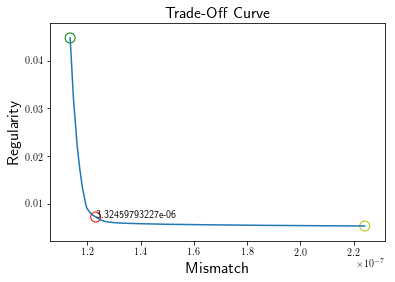

In [13]:
data_error = [res[1] for res in results]
reg_error = [res[2] for res in results]
lvals = [res[3] for res in results]

l_curve_distances = np.abs((reg_error[-1]-reg_error[0])*np.array(data_error) -  \
            (data_error[-1]-data_error[0])*np.array(reg_error)+data_error[-1]*reg_error[0]-reg_error[-1]*data_error[0])
best = np.argsort(l_curve_distances)[-1]

plt.plot( data_error, reg_error)
plt.scatter(data_error[best],reg_error[best],s=100, facecolors='none', edgecolors='r')
plt.scatter(data_error[0],reg_error[0],s=100, facecolors='none', edgecolors='g')
plt.scatter(data_error[-1],reg_error[-1],s=100, facecolors='none', edgecolors='y')

plt.xlabel("Mismatch", fontsize=16)
plt.ylabel("Regularity", fontsize=16)
plt.title('Trade-Off Curve', fontsize=16)
plt.text(data_error[best],reg_error[best],lvals[best])

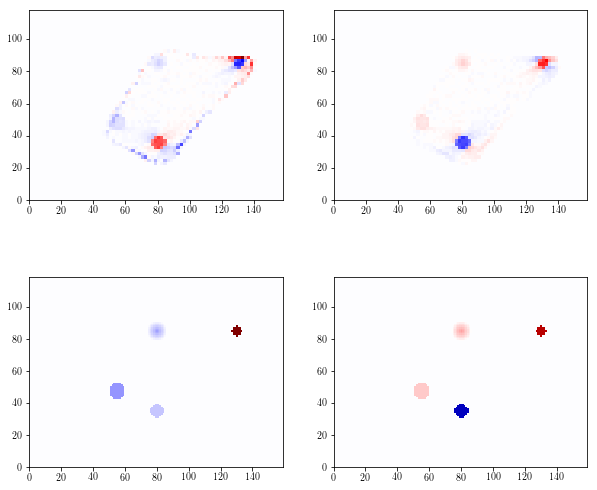

In [17]:
s_x = np.zeros(coords.shape[0])
s_y = np.zeros(coords.shape[0])

s_x[condition_inside] = results[best][0][0][:,0]
s_y[condition_inside] = results[best][0][0][:,1]
    

maxmagnitude = np.max(np.abs(s_y))

fig = plt.figure(figsize=(10,9))
plt.subplot(221)
plt.pcolormesh(x_obs_positions,y_obs_positions,s_x.reshape((len(y_obs_positions),len(x_obs_positions))),
                           cmap='seismic_r',vmax = maxmagnitude*2, vmin=-maxmagnitude*2).axes.set_aspect('equal')
plt.subplot(222)

plt.pcolormesh(x_obs_positions,y_obs_positions,s_y.reshape((len(y_obs_positions),len(x_obs_positions))),
                           cmap='seismic_r',vmax = maxmagnitude*2, vmin=-maxmagnitude*2).axes.set_aspect('equal')

plt.subplot(223)
plt.pcolormesh(x_forward_positions,y_forward_positions,imarray==0,
                           cmap='gray').axes.set_aspect('equal')
plt.pcolormesh(x_forward_positions,y_forward_positions,stress_x.reshape((M,N)),
                           cmap='seismic_r',vmax = maxmagnitude*2, vmin=-maxmagnitude*2).axes.set_aspect('equal')
plt.subplot(224)

plt.pcolormesh(x_forward_positions,y_forward_positions,imarray==0,
                           cmap='gray').axes.set_aspect('equal')
plt.pcolormesh(x_forward_positions,y_forward_positions,stress_y.reshape((M,N)),
                           cmap='seismic_r',vmax = maxmagnitude*2, vmin=-maxmagnitude*2).axes.set_aspect('equal')



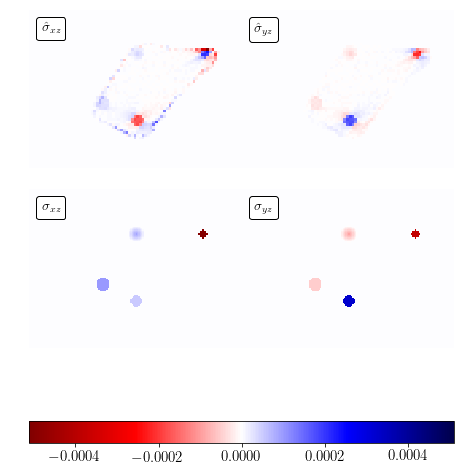

In [18]:
fig = plt.figure(figsize=(16,9))
#fig = plt.figure()
maxmagnitude = 0.03
gs0 = gridspec.GridSpec(2,1, hspace = .1,wspace=.1)

gs_j = []
gs_j_innergrids = []
ax = []
im = []
 
j = 0

gs_j += [gridspec.GridSpecFromSubplotSpec(1,2,
            subplot_spec=gs0[0],
            width_ratios = [1,1], hspace = 0.1,wspace=0.1)]
            #height_ratios = [1,1,1,1,1,1,1])]
gs_j_innergrids+= [[]]

gs_j_innergrids[j] +=  [gridspec.GridSpecFromSubplotSpec(1,2,
        subplot_spec = gs_j[j][0,0], wspace=0.0, hspace = 0.0)] 
ax += [plt.Subplot(fig, gs_j_innergrids[j][0][0,0])]
fig.add_subplot(ax[-1])

plt.axis('off')

at = AnchoredText("$\hat{\sigma}_{xz}$",
              prop=dict(size=14), frameon=True,
              loc=2,
              )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax[-1].add_artist(at)

z = np.ma.masked_array(s_x, np.abs(s_x) < 1e-5)    
maxmagnitude = np.max(np.abs(s_x))
im += [ax[-1].pcolormesh(x_obs_positions,y_obs_positions,s_x.reshape((len(y_obs_positions),len(x_obs_positions))),
                           cmap='seismic_r',vmax = maxmagnitude, vmin=-maxmagnitude)]

im[-1].axes.set_aspect('equal')
    
ax += [plt.Subplot(fig, gs_j_innergrids[j][0][0,1])]
fig.add_subplot(ax[-1])

plt.axis('off')

at = AnchoredText("$\hat{\sigma}_{yz}$",
              prop=dict(size=14), frameon=True,
              loc=2,
              )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax[-1].add_artist(at)

z = np.ma.masked_array(s_y, np.abs(s_y) < 1e-5)    
#maxmagnitude = np.max(np.abs(s_x))
im += [ax[-1].pcolormesh(x_obs_positions,y_obs_positions,s_y.reshape((len(y_obs_positions),len(x_obs_positions))),
                           cmap='seismic_r',vmax = maxmagnitude, vmin=-maxmagnitude)]

im[-1].axes.set_aspect('equal')

###########################################################
j = 1

gs_j += [gridspec.GridSpecFromSubplotSpec(1,2,
            subplot_spec=gs0[1],
            width_ratios = [1,1], hspace = 0.1,wspace=0.1)]
            #height_ratios = [1,1,1,1,1,1,1])]
gs_j_innergrids+= [[]]

gs_j_innergrids[j] +=  [gridspec.GridSpecFromSubplotSpec(1,2,
        subplot_spec = gs_j[j][0,0], wspace=0.0, hspace = 0.0)] 
ax += [plt.Subplot(fig, gs_j_innergrids[j][0][0,0])]
fig.add_subplot(ax[-1])

plt.axis('off')

at = AnchoredText("${\sigma}_{xz}$",
              prop=dict(size=14), frameon=True,
              loc=2,
              )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax[-1].add_artist(at)

z = np.ma.masked_array(stress_x, np.abs(stress_x) < 1e-5)    
#maxmagnitude = np.max(np.abs(s_x))
im += [ax[-1].pcolormesh(x_forward_positions,y_forward_positions,stress_x.reshape((len(y_forward_positions),len(x_forward_positions))),
                           cmap='seismic_r',vmax = maxmagnitude, vmin=-maxmagnitude)]

im[-1].axes.set_aspect('equal')
    
ax += [plt.Subplot(fig, gs_j_innergrids[j][0][0,1])]
fig.add_subplot(ax[-1])

plt.axis('off')

at = AnchoredText("${\sigma}_{yz}$",
              prop=dict(size=14), frameon=True,
              loc=2,
              )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax[-1].add_artist(at)

z = np.ma.masked_array(stress_y, np.abs(stress_y) < 1e-5)    
#maxmagnitude = np.max(np.abs(s_x))
im += [ax[-1].pcolormesh(x_forward_positions,y_forward_positions,stress_y.reshape((len(y_forward_positions),len(x_forward_positions))),
                           cmap='seismic_r',vmax = maxmagnitude, vmin=-maxmagnitude)]

im[-1].axes.set_aspect('equal')
#ax[0].text(100,220,r"Reconstruction",fontsize=20)
#ax[2].text(120,220,r"Difference",fontsize=20)
fig.colorbar(im[0], ax = ax, orientation='horizontal').ax.tick_params(labelsize=15)

    
plt.savefig("../figures/padfig_y.png",bbox_inches='tight', 
               transparent=True,
               pad_inches=0.15, dpi=400)   

In [19]:
results2 = [list(solution) for solution in results]

for solution in results2:

    s_x = np.zeros(coords.shape[0])
    s_y = np.zeros(coords.shape[0])
    
    s_x[condition_inside] = solution[0][0][:,0]
    s_y[condition_inside] = solution[0][0][:,1]
    
    solution.insert(0, [ s_x.reshape((len(y_obs_positions),len(x_obs_positions))), 
                   s_y.reshape((len(y_obs_positions),len(x_obs_positions))), 
                  x_obs_positions,y_obs_positions])
    #_ = solution.pop(1)

import pickle
import gzip

with gzip.open('results/pads_y.gz','wb') as f:
    pickle.dump(results2,f)